##**Introduction**:

Linear quadratic regulator (LQR) is a type of optimal control that is based on state space representation. Both pole placement and LQR are full state feedback control. They have the same structure as follows:
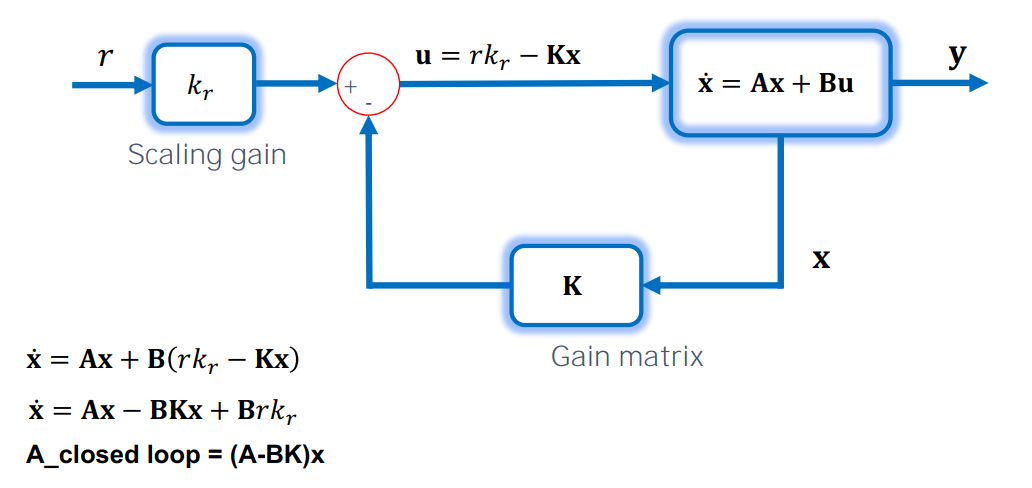

- $A$: captures the system dynamics (state matrix)
- $B$: input matrix
- $C$: output matrix
- $D$: direct transmission matrix (feedforward matrix)
- $K_r$: scaling term for steady state error
- $K$: gain matrix

Although they have the same structure, choosing $K$ is different.

In pole placement, we solve for $K$ by choosing poles locations that guarantee system stability. But in LQR, we find optimal $K$ by choosing the characteristics important to us. Basically, we consider how well the system performs and how much effort we pay (actuator effort).

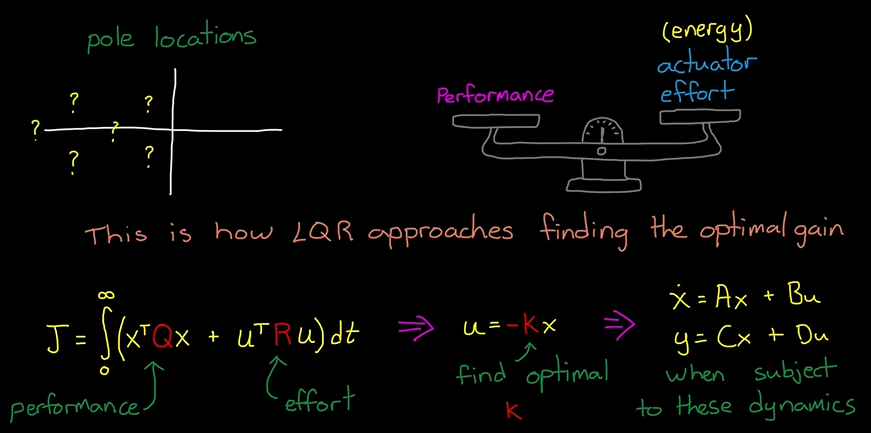

- In LQR, we set up a cost function that adds up the weighted sum of performance and effort overall time and then by solving the LQR problem, it returns the gain matrix that produces the lowest cost given the dynamics of the system.

- We penalize bad performance by adjusting Q, and we penalize actuator effort by adjusting R. The matrices need to be positive definite so that when we multiply it with the state vectors, the resulting value is positive and nonzero. And often it’s just a diagonal matrix with positive values along the diagonal.

- So let’s look at what performance means for this cost function. Performance is judged on the state vector. For now, let’s assume that we want every state to be zero, to be driven back to its starting equilibrium point. So if the system is initialized in some nonzero state, the faster it returns to zero, the better the performance is and the lower the cost. And the way that we can get a measure of how quickly it’s returning to the desired state is by looking at the area under the curve. This is what the integral is doing. A curve with less area means that it spends more time closer to the goal than a curve with more area.

- However, states can be negative or positive and we don’t want negative values subtracting from the overall cost, so we square the value to ensure that it’s positive. This has the effect of punishing larger errors disproportionately more than smaller ones, but it’s a good compromise because it turns our cost function into a quadratic function. Quadratic functions are convexed, and therefore, have a definite minimum value. And quadratic functions that are subject to linear dynamics remain quadratic so our system will also have a definite minimum value.

- With LQR, we don't place poles, we tune Q, and R. You can just start with identity matrix for both Q and R and then tweak them through trial and error and intuition about your system. This is much efficient as no need to think about which pole you should move in order to reduce the actuator effort.

The main idea in LQR control design is to minimize the quadratic cost function of int(x^TQx + u^TRu)dt. It turns out that regardless of the values of Q and R, the cost function has a unique minimum that can be obtained by solving the Algebraic Riccati Equation. The parameters Q and R can be used as design parameters to penalize the state variables and the control signals. The larger these values are, the more you penalize these signals. Basically, choosing a large value for R means you try to stabilize the system with less (weighted) energy. This is usually called expensive control strategy. On the other hand, choosing a small value for R means you don’t want to penalize the control signal (cheap control strategy). Similarly, if you choose a large value for Q means you try to stabilize the system with the least possible changes in the states and large Q implies less concern about the changes in the states. Since there is a trade-off between the two, you may want to keep Q as I (identity matrix) and only alter R. You can choose a large R, if there is a limit on the control output signal (for instance, if large control signals introduce sensor noise or cause actuator's saturation) , and choose a small R if having a large control signal is not a problem for your system.

In [ ]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete
from scipy.linalg import solve_discrete_are as dare 
from scipy.integrate import odeint 

##**Nonlinear System Dynamics**: 

Recall the dynamics of diff drive system:

\begin{equation} 
\begin{bmatrix}
\dot{x} \\ 
\dot{y} \\ 
\dot{\theta}
\end{bmatrix} 
= 
\begin{bmatrix}
\cos\theta & 0\\ 
\sin\theta & 0\\
0 & 1
\end{bmatrix} 
\begin{bmatrix}
v \\ 
ω 
\end{bmatrix} 
\end{equation}


Choosing the state to be $\mathbf{x} = [x, y, \theta]^T$ and setting $\mathbf{u} = [v, \omega]^T$One may rewrite this equation in the state-space form as:

\begin{equation} 
\mathbf{\dot{x}} = f(x,u)
\end{equation}
\begin{equation} 
\mathbf{\dot{x}} = B(x)u
\end{equation}


In [ ]:
def f(X, u):
    theta = X[2]
    v, w = u
    dx = sym.cos(theta)*v
    dy = sym.sin(theta)*v
    dtheta = w
    return dx, dy, dtheta

sym.init_printing()
x_sym = sym.symbols(r'x y \theta') 
u_sym = sym.symbols(r'v \omega') 
f_sym = sym.Matrix([f(x_sym, u_sym)]).T

f_sym

⎡v⋅cos(\theta)⎤
⎢             ⎥
⎢v⋅sin(\theta)⎥
⎢             ⎥
⎣   \omega    ⎦

###**Linearized Dynamics**: 

System above is nonlinear, the linear state space model should be obtained. A convinient way to do so is to linearize system dynamics nearby equilibrium point or desired trajectory:

\begin{equation}
\dot{\mathbf{x}}
= \mathbf{f}(\mathbf{x}_d,\mathbf{u}_d) +
\frac{\partial\mathbf{f}}{\partial\mathbf{x}}\Bigr\rvert_{\mathbf{x}_d,\mathbf{u}_d} 
(\mathbf{x} - \mathbf{x}_d) + 
\frac{\partial\mathbf{f}}{\partial\mathbf{u}}\Bigr\rvert_{\mathbf{x}_d,\mathbf{u}_d}  
(\mathbf{u} - \mathbf{u}_d)  + \text{H.O.T}
\end{equation}

Introducing the tracking error $\tilde{\mathbf{x}}$ we may rewrite the equation above in linear form as follows:

\begin{equation}
\dot{\tilde{\mathbf{x}}} = \mathbf{A}\tilde{\mathbf{x}} + \mathbf{B}\tilde{\mathbf{u}}   
\end{equation}
where: $\tilde{\mathbf{x}}$ is tracking error, $\tilde{\mathbf{u}}$ is the new control input $\mathbf{A} = \frac{\partial\mathbf{f}}{\partial\mathbf{x}}\Bigr\rvert_{\mathbf{x}_d,\mathbf{u}_d}$ - state evaluation matrix, $\mathbf{B} = \frac{\partial\mathbf{f}}{\partial\mathbf{u}}\Bigr\rvert_{\mathbf{x}_d,\mathbf{u}_d}$


Liniarization around the desired trajectory yields:

\begin{equation} 
\dot{\tilde{x}} 
=
\begin{bmatrix}
0 & 0 & -\sinθ_d v_d\\ 
0 & 0 & \cosθ_d v_d\\
0 & 0 & 0
\end{bmatrix}
\tilde{x} 
+ 
\begin{bmatrix}
\cos\theta_d & 0\\ 
\sin\theta_d & 0\\
0 & 1
\end{bmatrix}
\tilde{u} 
\end{equation}

\begin{equation} 
\dot{\tilde{x}} 
=
A_d
\tilde{x} 
+ 
B_d
\tilde{u} 
\end{equation}

Let us first calculate system jacobian with respect to state: $\frac{\partial\mathbf{f}}{\partial\mathbf{x}}$


In [ ]:
# Calculate the jacobian with respect to x
Jx_sym = f_sym.jacobian(x_sym)
Jx_sym

⎡0  0  -v⋅sin(\theta)⎤
⎢                    ⎥
⎢0  0  v⋅cos(\theta) ⎥
⎢                    ⎥
⎣0  0        0       ⎦

Now we can evaluate the jacobian nearby desired trajectory $\mathbf{A} = \frac{\partial\mathbf{f}}{\partial\mathbf{x}}\Bigr\rvert_{\mathbf{x}_d,\mathbf{u}_d}$


In [ ]:
# Evaluate J_x nearby desired trajectory
A_sym = Jx_sym

A_sym = A_sym.subs({x_sym[2]: 'theta_d'})
A_sym = A_sym.subs({u_sym[0]: 'v_d'})

A_sym.simplify()
A_sym

⎡0  0  -v_d⋅sin(θ_d)⎤
⎢                   ⎥
⎢0  0  v_d⋅cos(θ_d) ⎥
⎢                   ⎥
⎣0  0        0      ⎦

System jacobian with respect to control: $\frac{\partial\mathbf{f}}{\partial\mathbf{u}}$


In [ ]:
# calculate the jacobian with respect to u
Ju_sym = f_sym.jacobian(u_sym)
Ju_sym

⎡cos(\theta)  0⎤
⎢              ⎥
⎢sin(\theta)  0⎥
⎢              ⎥
⎣     0       1⎦

Now we may substitude the desired trajectory $\mathbf{B} = \frac{\partial\mathbf{f}}{\partial\mathbf{u}}\Bigr\rvert_{\mathbf{x}_d,\mathbf{u}_d}$


In [ ]:
B_sym = Ju_sym.subs(x_sym[2], 'theta_d')
B_sym

⎡cos(θ_d)  0⎤
⎢           ⎥
⎢sin(θ_d)  0⎥
⎢           ⎥
⎣   0      1⎦

Let's now create the numerical representation of system matrices as follows:

In [ ]:
# System matrix
def calc_A(theta_d, v_d):
  A = np.array([[0, 0, -np.sin(theta_d)*v_d],
                [0, 0, np.cos(theta_d)*v_d],
                [0, 0, 0]])
  return A

# Input matrix
def calc_B(theta_d):
  B = np.array([[np.cos(theta_d), 0],
                [np.sin(theta_d), 0],
                [0, 1]])
  return B

# Linearization around the upper equilibrium x_d = [0,0,0]
x_d = np.array([5,
                3,
                2])

u_d = [1,
       0]
        
theta_d = x_d[2]
v_d = u_d[0]
# A = calc_A(theta_d, v_d)
# B = calc_B(theta_d)
A = np.array(A_sym.subs({'theta_d':theta_d, 'v_d':v_d}), dtype = 'double')
B = np.array(B_sym.subs({'theta_d':theta_d}), dtype = 'double')
print(A)
print(B)

[[ 0.          0.         -0.90929743]
 [ 0.          0.         -0.41614684]
 [ 0.          0.          0.        ]]
[[-0.41614684  0.        ]
 [ 0.90929743  0.        ]
 [ 0.          1.        ]]


### **Discretization**
In practice the control is implemented in digital fashion, thus in order to design the control, system dynamics must be discretized and be presented in the form:

\begin{equation}
{\mathbf  {x}}[k+1]={\mathbf  A}_{d}{\mathbf  {x}}[k]+{\mathbf  B}_{d}{\mathbf  {u}}[k]
\end{equation}

In order to descretize system exactly, one just need to solve it on time interval $T$ (sampling time):

\begin{equation}
{\mathbf  A}_{d}=e^{{{\mathbf  A}T}}={\mathcal  {L}}^{{-1}}\{(s{\mathbf  I}-{\mathbf  A})^{{-1}}\}_{{t=T}}
\\
{\mathbf  B}_{d}=\left(\int _{{\tau =0}}^{{T}}e^{{{\mathbf  A}\tau }}d\tau \right){\mathbf  B}={\mathbf  A}^{{-1}}({\mathbf  A}_{d}-I){\mathbf  B}
\end{equation}

In [ ]:
# Find discrete matrices 
def discrete(theta_d, v_d, T):
  A = calc_A(theta_d, v_d)
  Ad = T*A + np.eye(3)

  B = calc_B(theta_d)
  Bd = B*T

  return Ad, Bd

# T = 1/500
# Ad, Bd = discrete(theta_d, v_d, T)
# print(Ad)
# print(Bd)

In [ ]:
C = np.diag([[1, 1, 1]])
D = np.zeros((3,2))

dT = 1/500

B_v = np.array([B[:,0]]).T
B_w = np.array([B[:,1]]).T

Ad, Bd, Cd, Dd, _ = cont2discrete((A,B,C,D), dT)
_, B_v_d, _, _, _ = cont2discrete((A,B_v,C,D), dT)
_, B_w_d, _, _, _ = cont2discrete((A,B_w,C,D), dT)

print(f"Exact discretization:\n {Ad, Bd}")

Exact discretization:
 (array([[ 1.00000000e+00,  0.00000000e+00, -1.81859485e-03],
       [ 0.00000000e+00,  1.00000000e+00, -8.32293673e-04],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]), array([[-8.32293673e-04, -1.81859485e-06],
       [ 1.81859485e-03, -8.32293673e-07],
       [ 0.00000000e+00,  2.00000000e-03]]))


### **Discrete Time LQR**
For a discrete-time linear system described by:

\begin{equation}
\mathbf{x}_{k+1}=\mathbf{A} \mathbf{x}_{k}+\mathbf{B}\mathbf{u}_{k}
\end{equation}
with a performance index defined as:
\begin{equation}
J_c=\sum \limits _{{k=0}}^{{\infty }}\left(\mathbf{x}_{k}^{T}\mathbf{Q}\mathbf{x}_{k}+\mathbf{u}_{k}^{T}\mathbf{R}\mathbf{u}_{k}\right)
\end{equation}

the optimal control sequence minimizing the performance index is given by:
\begin{equation}
\mathbf{u}_{k}=-\mathbf{K} \mathbf{x}_{k}
\end{equation}

where:
\begin{equation}
\mathbf{K}=(\mathbf{R}+\mathbf{B}^{T}\mathbf{S}\mathbf{B})^{{-1}}\mathbf{B}^{T}\mathbf{S}\mathbf{A}
\end{equation}

and $\mathbf{S}$ is the unique positive definite solution to the discrete time algebraic Riccati equation (DARE):

\begin{equation}
\mathbf{S}=\mathbf{A}^{T}\mathbf{S}\mathbf{A}-(\mathbf{A}^{T}\mathbf{S}\mathbf{B})\left(\mathbf{R}+\mathbf{B}^{T}\mathbf{S}\mathbf{B}\right)^{{-1}}(\mathbf{B}^{T}\mathbf{S}\mathbf{A})+\mathbf{Q}
\end{equation}

In [ ]:
def dlqr(A, B, Q, R):
    '''Discrete time LTI LQR'''
    # Solve discrete Ricatti equation (DARE)
    P = dare(A, B, Q, R)
    # Compute the LQR gain
    K = np.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)
    return K, P

Let us find the descrete LQR gain that minimize the cost above while highly penelazing the thrust vector: 

In [ ]:
Q = np.diag([20,20,20])
R = np.diag([1, 1]) 
K, P = dlqr(Ad, Bd, Q, R)

For the linearized plant, K should place poles (eigen values) on the left-hand side of complex plane:

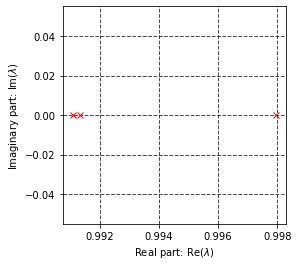

[0.99794714 0.99133281 0.99109564]


In [ ]:
# Calculate the LQR
# K = np.array([[0, 0, 0], [0, 0, 0]])
# print(B@K)
# Check the closed loop poles 
Ac = Ad - Bd@K
eigs = np.linalg.eigvals(Ac)

# Get the plot of desired and designed poles 
plt.figure(figsize=(4, 4))
plt.plot(eigs.real, eigs.imag, 'rx',label='Actual')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.xlabel(r'Real part: ${ \operatorname{Re}(\lambda)}$')
plt.ylabel(r'Imaginary part: ${ \operatorname{Im}(\lambda)}$')
plt.show()

print(eigs)

###**Simulation**:

As for now we find the controller to be:

\begin{equation}
\mathbf{u}_{k}=-\mathbf{K} \mathbf{x}_{k}
\end{equation}

Let us simulate the controller on two systems:

1.   Linear discrete system:
\begin{equation}
\mathbf{x}_{k+1}=\mathbf{A} \mathbf{x}_{k}+\mathbf{B}\mathbf{u}_{k}
\end{equation}

2.   Nonlinear continues system, solved on discrete time instances (discrete control, continues dynamics):
\begin{equation}
\mathbf{x}_{k+1}=\int_{t_k}^{t_k + dT} \mathbf{f}(\mathbf{x}(\tau),\mathbf{u}_k) d\tau 
\end{equation}



We proceed with the simulation of designed controller, firstly we will define the simulation parameters: 

In [ ]:
# Time settings
t0 = 0 # Initial time 
tf = 10 # Final time
N = int(2E3) # Numbers of points in time span
t = np.linspace(t0, tf, N) # Create time span

# Define initial point 
x_0 = 2.0
y_0 = 1.0
theta_0 = 0

# Set initial state 
x0 = np.array([x_0,
               y_0,
               theta_0])


####**Linearized dynamics**: 
Now let us simulate the response of linear controller on the **linearized** system:

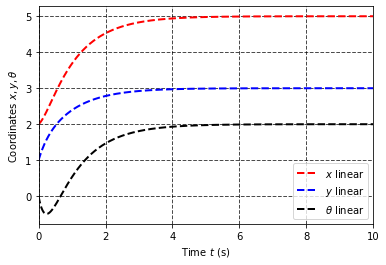

In [ ]:
# desired state derivative f(x_d, u_d)
# f_d = np.array([u_d[0]*np.cos(x_d[2]), u_d[0]*np.sin(x_d[2]), u_d[1]])
f_d = np.array(f_sym.subs({x_sym[2]:theta_d, u_sym[0]:u_d[0], u_sym[1]:u_d[1]}), dtype = 'double').reshape(-1)

# Define the linear ODE to solve
def linear_closed(x, t, A, B, K):
    # linearization is defined w.r.t. deflections in state and command value
    x_hat = x - x_d       # state deflection
    u = - np.dot(K,x_hat) # Linear controller
    u_hat = u - u_d       # command deflection
    # linearized state derivative
    dx = f_d + np.dot(A,x_hat) + np.dot(B,u_hat)
    # in our case f(x_d, u_d) = B*u_d therefore the expresion can be simplified as dx = np.dot(A,x_hat) * np.dot(B,u)
    return dx

# integrate system "sys_ode" from initial state $x0$
X_l = odeint(linear_closed, x0, t, args=(A, B, K,)) 

x_l, y_l, theta_l = X_l[:,0], X_l[:,1], X_l[:,2] 
# Plot the resulst
plt.plot(t, x_l, 'r--', linewidth=2.0, label = r'$x$ linear')
plt.plot(t, y_l, 'b--', linewidth=2.0, label = r'$y$ linear')
plt.plot(t, theta_l, 'k--', linewidth=2.0, label = r'$\theta$ linear')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.legend()
plt.xlim([t0, tf])
plt.ylabel(r'Coordinates $x,y,\theta$')
plt.xlabel(r'Time $t$ (s)')
plt.show()

####**Nonlinear dynamics**: 

First of all let us define the nonlinear system in form $\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \mathbf{u})$ :

In [ ]:
s, c = np.sin, np.cos
# Nonlinear boat dynamics
def f(X, u):
    x, y, theta = X
    v, w = u
    dx = c(theta)*v
    dy = s(theta)*v
    dtheta = w
    return dx, dy, dtheta

Now we will simulate similarly to linear case while using the same gains $\mathbf{K}$:

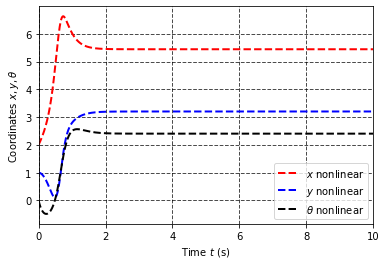

In [ ]:
def nonliear_closed(x, t = 0 , K = K):
    e = x - x_d
    # Linear controller
    u = - np.dot(K,e)  
    # Nonlinear dynamics
    # dx = f(x, u)
    dx = np.array(f_sym.subs({x_sym[2]:x[2], u_sym[0]:u[0], u_sym[1]:u[1]}), dtype = 'double').reshape(-1)
    return dx

# integrate system "sys_ode" from initial state $x0$
X_nl = odeint(nonliear_closed, x0, t, args=(K,)) 
x_nl, y_nl, theta_nl = X_nl[:,0], X_nl[:,1], X_nl[:,2] 
# Plot the resulst
plt.plot(t, x_nl, 'r--', linewidth=2.0, label = r'$x$ nonlinear')
plt.plot(t, y_nl, 'b--', linewidth=2.0, label = r'$y$ nonlinear')
plt.plot(t, theta_nl, 'k--', linewidth=2.0, label = r'$\theta$ nonlinear')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.legend()
plt.xlim([t0, tf])
plt.ylabel(r'Coordinates $x,y,\theta$')
plt.xlabel(r'Time $t$ (s)')
plt.show()

- controllability: $\exists$ control signals which allow the system to reach any state in a finte amount of time.
- observability: All states can be know from the system outputs.
- Region of attraction (RoA)